In [1]:
import orbipy as op
import numpy as np
import pickle

from instruments import instruments

/tmp/ipykernel_2175987/2152835073.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  instruments.icm_contour_visualizer(data).show()


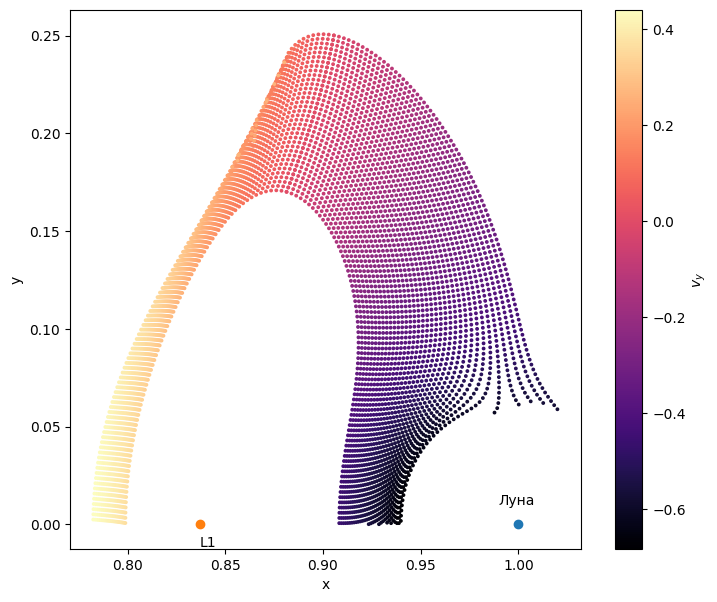

In [2]:
with open(r"../data/contour_points/icm_contour_data_spl.pickle", "rb") as input_file:
    data = pickle.load(input_file)

instruments.ism_contour_visualizer(data).show()

In [ ]:
class zero_correction(op.corrections.base_correction):
    def __init__(self, model, direction):
        super().__init__(model, direction)

    def calc_dv(self, t, s):
        return model.get_zero_state()

def generate_sum_dv_for_contour_line(model, contour_line_data, T):
    """
    Given a contour line, calculates a sum total of dv from impulse corrections for each point.
    :param contour_line_data: an array of contour line points
    :param T: Total integration time, in units
    :return: array [ [[x,z,vy], sum_dv], [[x,z,vy], sum_dv], [[x,z,vy], sum_dv], ... ]
    """
    def find_approximate_half_period(model, state, first_correction, correction):
        """
        Finds half-period for a given orbit state.
        :return: float, half-period in units. returns pi/2 if failed.
        """
        event = op.eventY(count=3, terminal=True)
        impulse_correction = op.simple_station_keeping(model, first_correction, correction, rev=np.pi/4,
                                                       events=[event], verbose=False)

        try:
            _ = impulse_correction.prop(0, state, 20)
        except (RuntimeError, ValueError) as e:
            print(f"    Failed to compute half period: {e}; setting default value of np.pi/2")
            return np.pi / 2

        time = impulse_correction.evout[:3, 3]
        half_period = time[-1] - time[-2] # difference between two x-axis trajectory intersections
        return half_period

    def impulse_correction_sum_dv(model, state, cj, T):
        """
        Calculates sum total of dv correction impulses for a state.
        :param T: Total integration time, in units
        :return: np.float64 dv_sum
        """
        print(f"    Calculating dv sum for state[{state}]:")
        initial_state = model.get_zero_state()

        initial_state[0] = state[0]
        initial_state[2] = state[1]
        initial_state[4] = state[2]

        left = op.eventSPL(model, cj, accurate=False)
        right = op.eventSPL(model, cj, accurate=False, left=False)

        correction = op.border_correction(model, op.unstable_direction(model), [left], [right], dv0=0.03, maxt=1000.)
        first_correction = zero_correction(model, op.unstable_direction(model)) # first correction is zero-correction because we already know the initial velocity from the provided icm

        half_period = find_approximate_half_period(model, initial_state, first_correction, correction)
        n = int(2 * (T // half_period))  # number of integrations, = 2 * ( total_time / time_of_one_integration )
        # * w because we use quarter period as the rev time
        print(f'        half_period: {half_period}, number of corrections: {n}')

        impulse_correction = op.simple_station_keeping(model, first_correction, correction, rev=half_period / 2)
        # quarter period is the most optimal rev time

        try:
            _ = impulse_correction.prop(0, initial_state, n)
        except (RuntimeError, ValueError) as e:
            print(f"    Failed to compute dv sum for state[{state}].")
            return -1

        dv_norms = np.linalg.norm(impulse_correction.dvout[:, 3:6], axis=1)
        return np.sum(dv_norms)

    line_output = []

    zvl_state = model.get_zero_state().copy()
    zvl_state[[0, 2]] = contour_line_data[0][0], contour_line_data[0][1]
    cj = model.jacobi(zvl_state)  # Get jacobi constant from the zero velocity line point
    print(f"    Jacobi constant of the contour line: {model.jacobi(zvl_state)}")

    for state in contour_line_data:
        sum_dv = impulse_correction_sum_dv(model, state, cj, T)
        print(f'    dv sum: {sum_dv}')
        line_output.append([state, sum_dv])

    return line_output

In [ ]:
model = op.crtbp3_model('Earth-Moon (default)', integrator=op.dopri5_integrator(), stm=True)
one_thousand_kms = (1 - model.L1) / 61.350

T = 32
sumdv_map = []
for _, contour_line in enumerate(data):
    print(f"Calculating sumdv map for contour {_}, {"right" if _ % 2 == 0 else "left"} side:")
    contour_line_data = generate_sum_dv_for_contour_line(model, contour_line, T)
    sumdv_map.append(contour_line_data)

    with open("../data/contour_points/sumdv_maps/vcsm_contour_data_planes_3.pickle", 'wb') as f:
        pickle.dump(sumdv_map, f, protocol=pickle.HIGHEST_PROTOCOL)
print("Finished.")

In [ ]:
instruments.vcsm_contour_visuzalizer(sumdv_map).show()